# 1. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import *
import torchvision

# 2. Stochastic Gradient Descent

**전체 데이터셋이 아니라 일부 샘플(1개 또는 소수의 샘플)만 사용하여 파라미터를 업데이트하는 것**

`-` SGD가 왜 필요해?

GPU는 사기니까 GPU만 사용하면 될 것 같음 그런데 GPU는 너무 비싸다... 80GB에 3000만원씩 하기때문...

80GB는 금방 차버리니까 그럼 GPU메모리를 어떻게든 아껴서 잘 사용해야하네?

어떻게 해야할까?

In [2]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

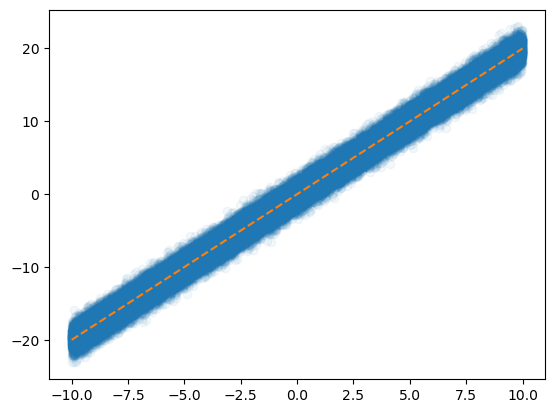

In [3]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,2*x,'--')

그렇게 어려운 계산도 아닌데 10만개의 데이터를 모두 GPU로 보내서 연산시키면 너무 낭비라는 생각이 듦...

## A. X,y 데이터를 모두 굳이 GPU에 넘겨야 하는가?

데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면 안되나?

`-` 아래의 알고리즘을 생각해보자.

1. 데이터를 반으로 나누고
2. 짝수 obs의 x,y,net의 모든 parameters을 GPU에 올린다
3. yhat,loss,grad,update 수행
4. 홀수 obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수 obs의 x,y를 GPU메모리에 올린다
5. yhat,loss,grad,update 수행
6. 반복

## B. 미니배치 경사하강법

그럼 홀수 짝수로 나누는 건 2로 나누는 건데 굳이 2로만 나누어야하나? 더 쪼갤 수 있지 않나?

`-` gradient descent : 10개의 sample data가 있다고 할 때 모든 sample을 이용하여 slope계산

`-` stochastic gradient descent with batch size = 1 : 10개의 smaple data를 하나씩으로 모두 쪼개서 slope계산

stochastic gradient descent with batch size = 1의 경우는 epoc을 10번 하면 총 100번 epoc을 돌리는 것과 같다

`-` stochastic gradient descent : m개의 sample을 이용하여 slope 계산

그럼 stochastic gradient descent의 경우는 epoc을 10번 하면 총 40번 epoc을 돌리는 것과 같다.

## C. Dataset(ds) , DataLoader(dl)

stochastic gradient descent를 수행하기 위해서 파이토치에서는 ds와 dl라는 오브젝트를 준비했다.

In [11]:
x=torch.tensor(range(10)).float().reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5).reshape(-1,1)
torch.concat([x,y],axis=1)

tensor([[0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 0.],
        [6., 0.],
        [7., 0.],
        [8., 0.],
        [9., 0.]])

In [12]:
ds = torch.utils.data.TensorDataset(x,y)

dir(ds)를 살펴보면 __getitem__이 있다 이러면 섭스크립터블하다는 것이다.

In [13]:
ds.tensors # 튜플 언패킹으로 뽑을 수 있을 거 같음

(tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [14]:
ds[0] , (x,y)[0]

((tensor([0.]), tensor([1.])),
 tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]))

그런데 일반적인 튜플의 인덱싱과는 다르게 동작함

In [15]:
dl=torch.utils.data.DataLoader(ds,batch_size=3)
dl

dl : 섭스크립터블하지 않지만 이터러블 함 즉, for문을 사용할 수 있음

In [16]:
for xi,yi in dl:
    print(xi,yi)

tensor([[0.],
        [1.],
        [2.]]) tensor([[1.],
        [1.],
        [1.]])
tensor([[3.],
        [4.],
        [5.]]) tensor([[1.],
        [1.],
        [0.]])
tensor([[6.],
        [7.],
        [8.]]) tensor([[0.],
        [0.],
        [0.]])
tensor([[9.]]) tensor([[0.]])


10을 3으로 나누면 마지막에 하나 남는데 그건 어떻게 해? -> 그냥 하나 남으면 그것만 계산한다

## D. ds,dl을 이용한 MNIST구현

`-` 목표 : 확률적경사하강법과 그냥 경사하강법의 성능을 '동일 반복횟수'로 비교해보자

`-` 그냥 경사하강법 - mini-batch쓰지 않는 학습

In [17]:
path = untar_data(URLs.MNIST)
X0 = torch.stack(([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()]))
X1 = torch.stack(([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()]))
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

torch.manual_seed(21345)
net = torch.nn.Sequential(
    torch.nn.Linear(1*28*28,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

for epoc in range(700):
    yhat = net(X)
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

((yhat > 0.5)*1.0 == y).float().mean()

tensor(0.9998)

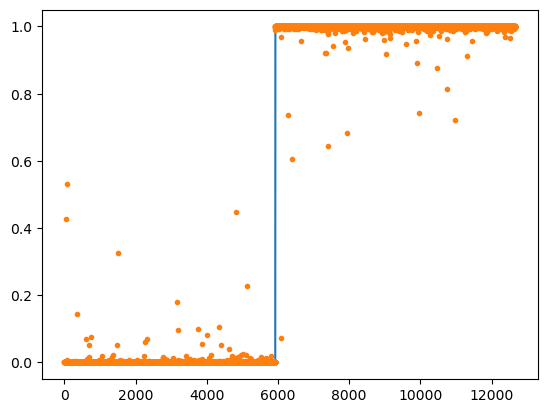

In [18]:
plt.plot(y)
plt.plot(yhat.data,'.')

`-` '확률적' 경사하강법 - mini-batch사용하는 학습

In [20]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)

path = untar_data(URLs.MNIST)
X0 = torch.stack(([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()]))
X1 = torch.stack(([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()]))
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

torch.manual_seed(21345)
net = torch.nn.Sequential(
    torch.nn.Linear(1*28*28,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

for epoc in range(100):
    for xi,yi in dl:
        netout = net(xi)
        loss = loss_fn(netout,yi)
        loss.backward()
        optimizr.step()
        optimizr.zero_grad()

((net(X) > 0.5)*1.0 == y).float().mean()

tensor(0.9992)

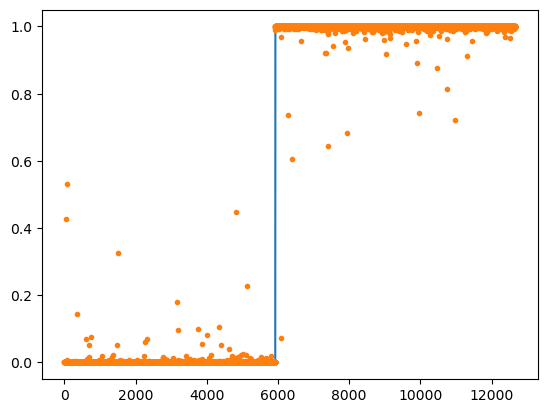

In [123]:
plt.plot(y)
plt.plot(yhat.data,'.')

`-` GPU를 활용하는 '확률적' 경사하강법 - 실제로는 이게 최종 알고리즘

In [21]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)

path = untar_data(URLs.MNIST)
X0 = torch.stack(([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()]))
X1 = torch.stack(([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()]))
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

torch.manual_seed(21345)
net = torch.nn.Sequential(
    torch.nn.Linear(1*28*28,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

for epoc in range(100):
    for xi,yi in dl:
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        loss.backward()
        optimizr.step()
        optimizr.zero_grad()

net.to("cpu")

((net(X) > 0.5)*1.0 == y).float().mean()

tensor(0.9992)

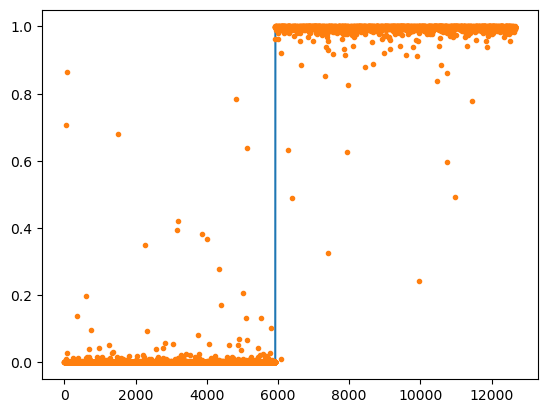

In [131]:
plt.plot(y)
plt.plot(net(X).data.data,'.')

# 5. 다중클래스 분류

## A. 결론

`-` 2개의 class를 구분하는 게 아니라 k개의 class를 구분해야 한다면?

y의 형태 : (n,) vector + int형 // (n,k) one-hot encoded matrix + float형

손실함수 : torch.nn.BCEWithLogitsLoss, -> torch.nn.CrossEntropyLoss

마지막층의 선형변환 : torch.nn.Linear(?,1) -> torch.nn.Linear(?,k)

마지막층의 활성화 : NONE -> NONE (손실함수에 이미 포함되어있음)

## B. 실습 : 3개의 클래스를 구분

In [133]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3), # class = 3
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합 
for epoc in range(100):
    ## step1 
    netout = net(X)
    ## step2 
    loss = loss_fn(netout,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()
## Step4: 적합 (혹은 적합결과확인)    
(netout.argmax(axis=1) == y).float().mean()

tensor(0.9827)

파이토치에서 CrossEntropyLoss를 사용하면 one-hot 인코딩을 해준다. float형도 자동으로 맞춰줌

## D.정리

`-` 결론

1. 소프트맥스는 시그모이드의 확장이다.
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다.

`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (그냥 좀 비효율적인 느낌이 드는 것 뿐임. 흑백이미지를 칼라잉크로 출력하는 느낌)